In [1]:
import os
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from model.Displacement.generation import WCGAN_GP
from dataset.Displacement.DataGeneration import DamageDataGenerationDataset
from model.Displacement.extraction import TripletAE
from torch.utils.data import DataLoader

/home/tingyan/.conda/envs/icshm/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [17]:
tAE = TripletAE.load_from_checkpoint("./Logs/Extraction/Displacement-TripletAE/unet/version_0/checkpoints/epoch=00466-val_loss=0.00045464.ckpt").to("cuda")
WCGAN = WCGAN_GP.load_from_checkpoint("./Logs/Generation/Displacement_WCGAN_GP/First/version_0/checkpoints/epoch=00000-fid=0.0000.ckpt", strict=False).to("cuda")

/home/tingyan/.conda/envs/icshm/lib/python3.10/site-packages/pytorch_lightning/core/saving.py:255: UserWarning: Found keys that are not in the model state dict but in the checkpoint: ['AE.classifier.fc.0.weight', 'AE.classifier.fc.0.bias', 'AE.classifier.fc.2.weight', 'AE.classifier.fc.2.bias']
  rank_zero_warn(


In [18]:
train_dataset = DamageDataGenerationDataset(path="./Data", task="classification")
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True) 

In [19]:
real_data_list = []
generative_data_list = []

real_representation_list = []
generative_representation_list = []

situation_list = []

with torch.no_grad():
    for real_data, condition, situation in train_dataloader:
        z = torch.rand((condition.shape[0], 82)).to("cuda")
        condition = condition.to("cuda")
        real_data = real_data.to("cuda")

        synthetic_data = WCGAN(z, condition)

        real_data_list += real_data.unsqueeze(0)
        generative_data_list += synthetic_data.unsqueeze(0)

        real_representation_list += tAE(real_data)[-1].unsqueeze(0)
        generative_representation_list += tAE(synthetic_data)[-1].unsqueeze(0)

        situation_list += situation.unsqueeze(0)


real_data_list = torch.concat(real_data_list).cpu().numpy()
generative_data_list = torch.concat(generative_data_list).cpu().numpy()

real_representation_list = torch.concat(real_representation_list).cpu().numpy()
generative_representation_list = torch.concat(generative_representation_list).cpu().numpy()

situation_list = torch.concat(situation_list).cpu().numpy()

In [20]:
from sklearn.manifold import TSNE

def draw_tsne(synthetic_latent, input_latent, situation):
    synthetic_latent = np.reshape(synthetic_latent, (synthetic_latent.shape[0], -1))
    input_latent = np.reshape(input_latent, (input_latent.shape[0], -1))
    synthetic_embedded = TSNE(n_components=2, learning_rate='auto', init='random').fit_transform(synthetic_latent)
    real_embedded = TSNE(n_components=2, learning_rate='auto', init='random').fit_transform(input_latent)
    fig = plt.figure(figsize=(15,10))
    plt.scatter(synthetic_embedded[:, 0], synthetic_embedded[:, 1], c=situation,  marker="+", alpha=0.8, cmap="Set3")
    plt.scatter(real_embedded[:, 0], real_embedded[:, 1], c=situation, marker=".", alpha=0.8,  cmap="Set3")
    plt.savefig("Generation.svg", bbox_inches='tight')


In [21]:
def visualize(generated_data_sample, real_data_sample):
    fig, axes = plt.subplots(5, 1, figsize=(15,6))
    for i in range(5):
        line1 = axes[i].plot(range(len(real_data_sample[i, :])), real_data_sample[i, :], color="tab:blue",  label="Real Signal")
        line2 = axes[i].plot(range(len(generated_data_sample[i, :])), generated_data_sample[i, :], color="tab:red", linestyle='dashed', label="Generated Signal")
        axes[i].set_xticks([])
    fig.legend(handles =[line1[0], line2[0]], loc ='lower center', ncol=4)
    fig.savefig("Generated Siganl.svg", bbox_inches='tight')

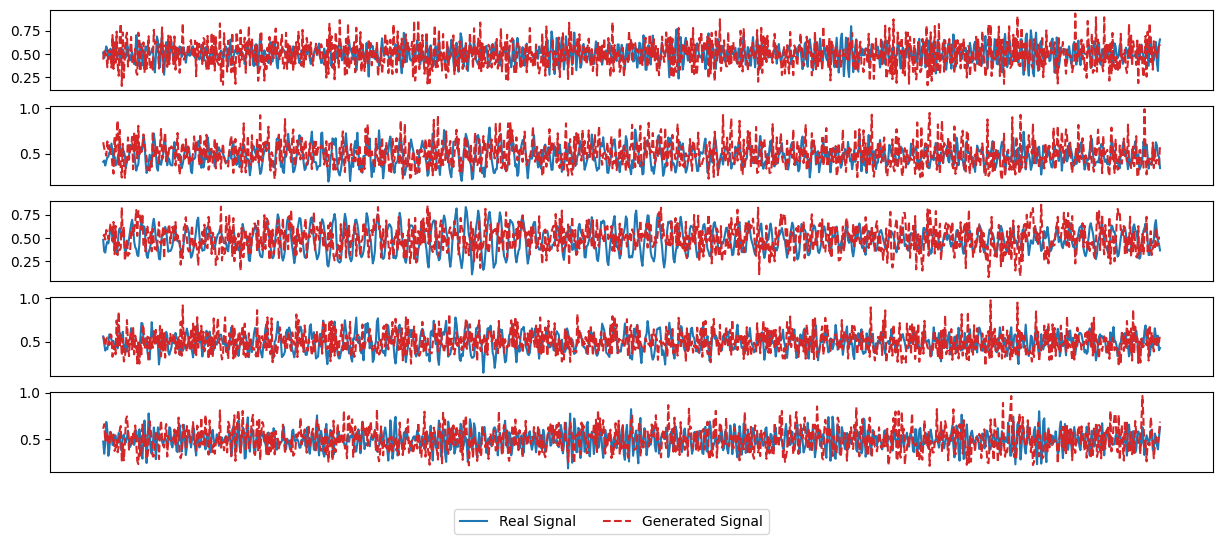

In [22]:
visualize(generative_data_list[0, :, :], real_data_list[0, :, :])

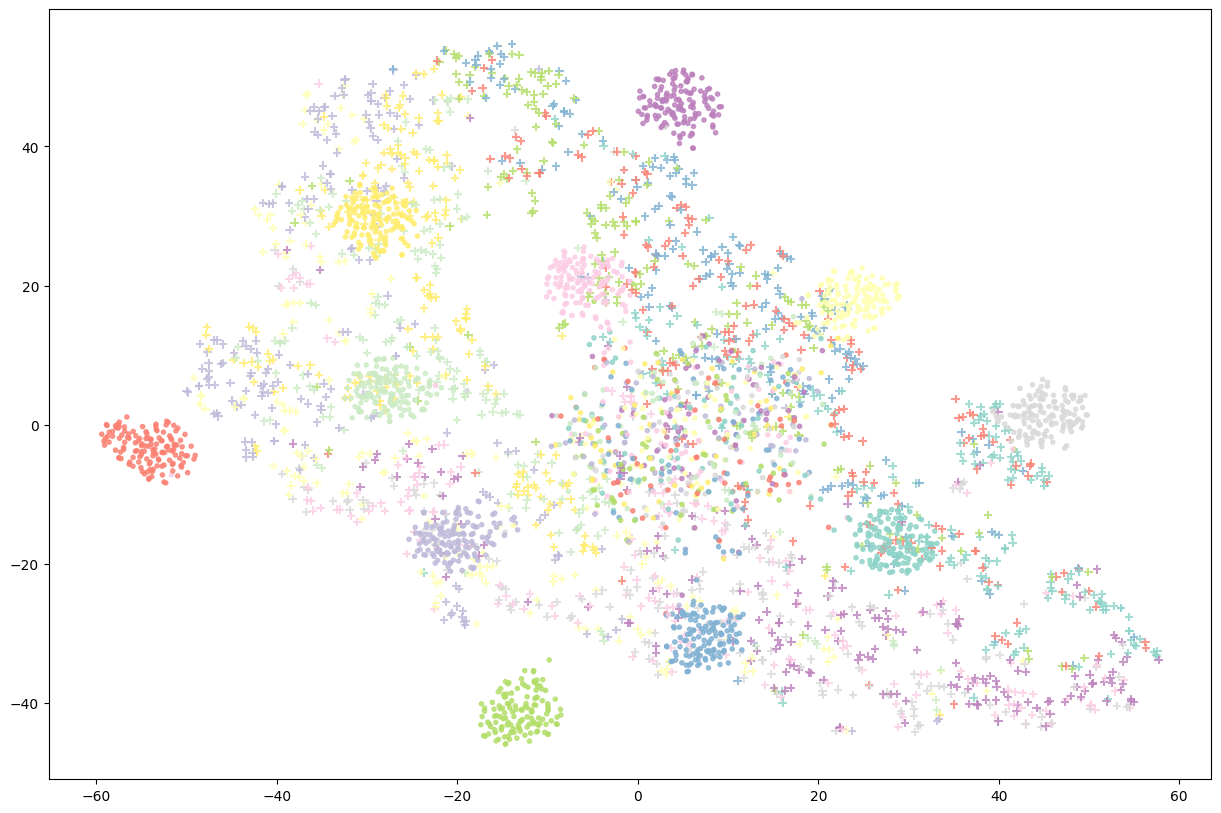

In [6]:
draw_tsne(generative_representation_list, real_representation_list, situation_list)